# TFID Model

In [29]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

# Load the dataset
file_path = '/content/labeled_job_descriptions.xlsx'
data = pd.read_excel(file_path)

# Data Cleaning Steps

# 1. Handle Missing Values
data.dropna(subset=['Job Description In English', 'Skills'], inplace=True)

# 2. Normalize Text
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

data['Job Description In English'] = data['Job Description In English'].apply(clean_text)

# 3. Preprocess the skills
def clean_skills(skills):
    skills_list = [skill.strip().lower() for skill in str(skills).split(',')]
    skills_list = list(set(skills_list))  # Remove duplicates
    skills_list = [skill for skill in skills_list if skill]  # Remove empty strings
    return skills_list

data['Skills'] = data['Skills'].apply(clean_skills)

# 4. Handle Rare Skills (Optional)
# Calculate skill frequency
skill_counts = {}
for skills in data['Skills']:
    for skill in skills:
        if skill in skill_counts:
            skill_counts[skill] += 1
        else:
            skill_counts[skill] = 1

# Remove skills that appear less than a certain threshold
threshold = 5  # Adjust based on your dataset
rare_skills = {skill for skill, count in skill_counts.items() if count < threshold}

def remove_rare_skills(skills):
    return [skill for skill in skills if skill not in rare_skills]

data['Skills'] = data['Skills'].apply(remove_rare_skills)

# Remove rows where Skills list is empty after removing rare skills
data = data[data['Skills'].map(len) > 0].reset_index(drop=True)

# Get all unique skills after cleaning
all_skills = set()
for skills in data['Skills']:
    all_skills.update(skills)

all_skills = sorted(list(all_skills))
print(f"Total unique skills after cleaning: {len(all_skills)}")

# Multi-label binarizer
mlb = MultiLabelBinarizer(classes=all_skills)
mlb.fit(data['Skills'])

# Transform skills into multi-hot encoding
y = mlb.transform(data['Skills'])

# Features
X = data['Job Description In English']

# Split the data into training and test sets (use the same random state for reproducibility)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf.fit(X_train_text)  # Fit only on training data
X_train = tfidf.transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# Build a logistic regression model wrapped in a OneVsRestClassifier for multi-label classification
model_Tfid = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Train the model
model_Tfid.fit(X_train, y_train)

# Predict on the test set
y_pred = model_Tfid.predict(X_test)


Total unique skills after cleaning: 27


#TFID Model Evaluation


In [30]:
# Evaluate the TF-IDF model
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score, precision_score, recall_score
)

# Predict on the test set
y_pred_tfidf = model_Tfid.predict(X_test)

# Calculate metrics
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='micro', zero_division=0)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf, average='micro', zero_division=0)
recall_tfidf = recall_score(y_test, y_pred_tfidf, average='micro', zero_division=0)

print("TF-IDF Model Performance on Test Set:")
print(f"F1 Score: {f1_tfidf:.4f}")
print(f"Accuracy: {accuracy_tfidf:.4f}")
print(f"Precision: {precision_tfidf:.4f}")
print(f"Recall: {recall_tfidf:.4f}")

# Get detailed classification report
report_tfidf = classification_report(
    y_test, y_pred_tfidf, target_names=mlb.classes_, zero_division=0, output_dict=True
)


TF-IDF Model Performance on Test Set:
F1 Score: 0.7841
Accuracy: 0.2815
Precision: 0.9865
Recall: 0.6506


#Skills Predict


In [32]:
def predict_skills(job_description):
    # Preprocess the input job description (similar to how we preprocessed the data)
    job_description_clean = clean_text(job_description)

    # Vectorize the input job description using the trained TF-IDF vectorizer
    job_description_vectorized = tfidf.transform([job_description_clean])

    # Use the trained model to predict the skills
    predicted_skills_vector = model_Tfid.predict(job_description_vectorized)

    # Convert the predicted vector back to skill labels
    predicted_skills = mlb.inverse_transform(predicted_skills_vector)

    # Return the predicted skills
    return predicted_skills

# Example usage:
user_input = input("Enter a job description: ")
predicted_skills = predict_skills(user_input)

if predicted_skills:
    print(f"Predicted skills for the job description: {', '.join(predicted_skills[0])}")
else:
    print("No skills could be predicted for this job description.")


Enter a job description: Mechanical Enginnering software
Predicted skills for the job description: 'engineering', 'software engineering'


#Bert

In [6]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK data (if needed)
nltk.download('stopwords')

# Load the data
df = pd.read_excel('/content/labeled_job_descriptions.xlsx')

# Data Cleaning

# 1. Handle Missing Values
df.dropna(subset=['Job Description In English', 'Skills'], inplace=True)

# 2. Normalize Text
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

df['Job Description In English'] = df['Job Description In English'].apply(clean_text)

# Optionally, remove stop words (commented out because BERT handles stop words)
# stop_words = set(stopwords.words('english'))
# df['Job Description In English'] = df['Job Description In English'].apply(
#     lambda x: ' '.join([word for word in x.split() if word not in stop_words])
# )

# 3. Preprocess the skills
def clean_skills(skills):
    skills_list = [skill.strip().lower() for skill in str(skills).split(',')]
    skills_list = list(set(skills_list))  # Remove duplicates
    skills_list = [skill for skill in skills_list if skill]  # Remove empty strings
    return skills_list

df['Skills'] = df['Skills'].apply(clean_skills)

# 4. Handle Rare Skills (Optional)
# Calculate skill frequency
skill_counts = {}
for skills in df['Skills']:
    for skill in skills:
        if skill in skill_counts:
            skill_counts[skill] += 1
        else:
            skill_counts[skill] = 1

# Remove skills that appear less than a certain threshold
threshold = 5  # Adjust based on your dataset
rare_skills = {skill for skill, count in skill_counts.items() if count < threshold}

def remove_rare_skills(skills):
    return [skill for skill in skills if skill not in rare_skills]

df['Skills'] = df['Skills'].apply(remove_rare_skills)

# Remove rows where Skills list is empty after removing rare skills
df = df[df['Skills'].map(len) > 0].reset_index(drop=True)

# Get all unique skills after cleaning
all_skills = set()
for skills in df['Skills']:
    all_skills.update(skills)

all_skills = sorted(list(all_skills))
print(f"Total unique skills after cleaning: {len(all_skills)}")

# Multi-label binarizer
mlb = MultiLabelBinarizer(classes=all_skills)
mlb.fit(df['Skills'])

# Transform skills into multi-hot encoding
y = mlb.transform(df['Skills'])

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset
class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    df['Job Description In English'],
    y,
    test_size=0.2,
    random_state=42
)

# Create datasets
train_dataset = JobDataset(X_train, y_train, tokenizer)
val_dataset = JobDataset(X_val, y_val, tokenizer)

# Define the model
num_labels = len(mlb.classes_)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Define compute_metrics
def compute_metrics(p):
    preds = p.predictions
    preds = torch.sigmoid(torch.tensor(preds))
    preds = preds.cpu().numpy()
    preds = (preds >= 0.5).astype(int)
    labels = p.label_ids
    f1 = f1_score(labels, preds, average='micro', zero_division=0)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='micro', zero_division=0)
    recall = recall_score(labels, preds, average='micro', zero_division=0)
    return {'f1': f1, 'accuracy': accuracy, 'precision': precision, 'recall': recall}


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Adjust based on your GPU memory
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',  # Add this line
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=1,  # Only save the best model
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the model
trainer.save_model('bert_job_skills_model')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total unique skills after cleaning: 27


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.061900,0.060328,0.971313,0.805411,0.984728,0.958258
2,0.032100,0.027518,0.990258,0.927159,0.995300,0.985268
3,0.013900,0.020253,0.993965,0.953694,0.998175,0.989791


#Testing with a job description

In [22]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model
num_labels = len(mlb.classes_)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Move the model to the device
model.to(device)



def predict_skills(text):
    text = clean_text(text)  # Apply the same cleaning as training data
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)          # Move to device
    attention_mask = encoding['attention_mask'].to(device)  # Move to device

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        preds = preds.detach().cpu().numpy()
        preds = (preds >= 0.5)
        predicted_skills = mlb.inverse_transform(preds)
    return predicted_skills

# Example usage
text = "We are looking for a software engineer with experience in Python and machine learning."
predicted_skills = predict_skills(text)
print("Predicted Skills:", predicted_skills)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Skills: [("'accounting'", "'agriculture'", "'data analysis'", "'engineering'", "'finance'", "'food service'", "'legal'", "'manufacturing'", "'marketing'", "'research'", "'transportation'")]


#Bert Model Evaluation

In [33]:
# Evaluate the BERT model
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score, precision_score, recall_score
)
import numpy as np

# Function to get predictions and true labels from the dataset
def get_predictions_from_model(model, dataset, batch_size=4):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits)
            preds = (preds >= 0.5).float()
            predictions.append(preds.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    return predictions, true_labels

# Get predictions and true labels
bert_preds, bert_true = get_predictions_from_model(model, val_dataset)

# Calculate metrics
f1_bert = f1_score(bert_true, bert_preds, average='micro', zero_division=0)
accuracy_bert = accuracy_score(bert_true, bert_preds)
precision_bert = precision_score(bert_true, bert_preds, average='micro', zero_division=0)
recall_bert = recall_score(bert_true, bert_preds, average='micro', zero_division=0)

print("BERT Model Performance on Test Set:")
print(f"F1 Score: {f1_bert:.4f}")
print(f"Accuracy: {accuracy_bert:.4f}")
print(f"Precision: {precision_bert:.4f}")
print(f"Recall: {recall_bert:.4f}")

# Get detailed classification report
report_bert = classification_report(
    bert_true, bert_preds, target_names=mlb.classes_, zero_division=0, output_dict=True
)


BERT Model Performance on Test Set:
F1 Score: 0.1672
Accuracy: 0.0000
Precision: 0.1132
Recall: 0.3197


#Comparison Table

In [34]:
import pandas as pd

# Create a DataFrame to hold the comparison
comparison_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Accuracy', 'Precision', 'Recall'],
    'TF-IDF Model': [f1_tfidf, accuracy_tfidf, precision_tfidf, recall_tfidf],
    'BERT Model': [f1_bert, accuracy_bert, precision_bert, recall_bert]
})

print("\nComparison of Models:")
print(comparison_df)



Comparison of Models:
      Metric  TF-IDF Model  BERT Model
0   F1 Score      0.784051    0.167157
1   Accuracy      0.281478    0.000000
2  Precision      0.986479    0.113159
3     Recall      0.650556    0.319721


#Comparison Visualzation

Simple bar chart

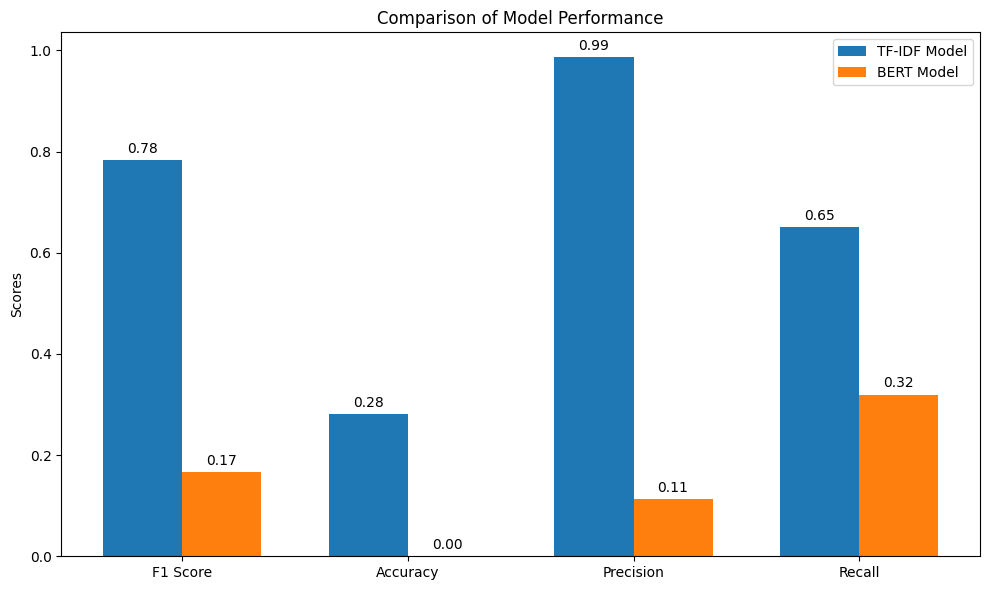

In [25]:
import matplotlib.pyplot as plt

# Set up the data
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
tfidf_scores = [f1_tfidf, accuracy_tfidf, precision_tfidf, recall_tfidf]
bert_scores = [f1_bert, accuracy_bert, precision_bert, recall_bert]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, tfidf_scores, width, label='TF-IDF Model')
rects2 = ax.bar(x + width/2, bert_scores, width, label='BERT Model')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


Plotting ROC Curves

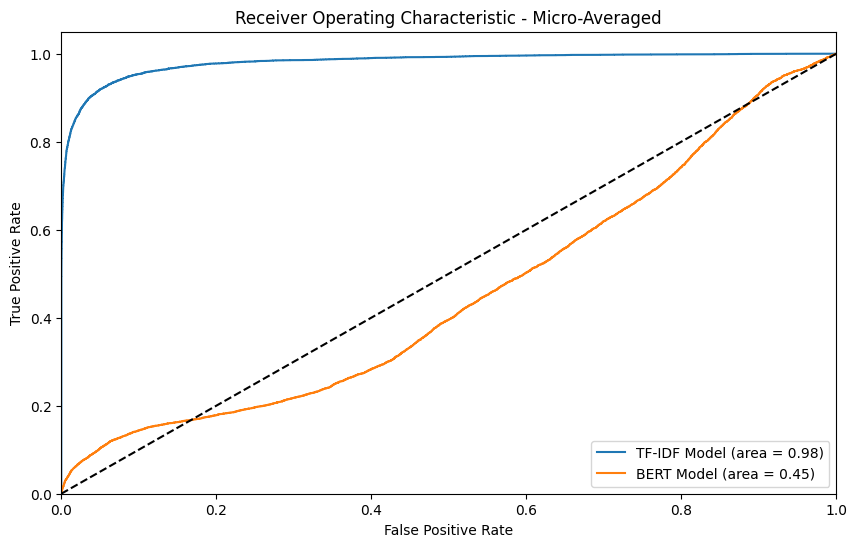

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For TF-IDF Model
# Get the decision function scores
try:
    y_score_tfidf = model_Tfid.decision_function(X_test)
except AttributeError:
    # If decision_function is not available, use predict_proba instead
    y_score_tfidf = model_Tfid.predict_proba(X_test)

# For BERT Model
# Get the logits from the BERT model
def get_logits_from_model(model, dataset, batch_size=4):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    model.eval()
    logits_list = []
    true_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            logits_list.append(logits.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    logits = np.vstack(logits_list)
    true_labels = np.vstack(true_labels)
    return logits, true_labels

bert_logits, bert_true_labels = get_logits_from_model(model, val_dataset)

# Compute ROC curve and ROC area for each model
from sklearn.metrics import roc_auc_score

# Binarize the labels for ROC curve computation
# (Though in multi-label classification, labels are already in binary format)

# For TF-IDF Model
# If using predict_proba, take the probability estimates
if hasattr(model_Tfid, 'decision_function'):
    y_score_tfidf = model_Tfid.decision_function(X_test)
else:
    y_score_tfidf = model_Tfid.predict_proba(X_test)

# Compute micro-average ROC curve and ROC area for TF-IDF Model
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test.ravel(), y_score_tfidf.ravel())
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

# Compute micro-average ROC curve and ROC area for BERT Model
fpr_bert, tpr_bert, _ = roc_curve(bert_true_labels.ravel(), bert_logits.ravel())
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF Model (area = {roc_auc_tfidf:.2f})')
plt.plot(fpr_bert, tpr_bert, label=f'BERT Model (area = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Micro-Averaged')
plt.legend(loc="lower right")
plt.show()


Visualizing Classification Reports

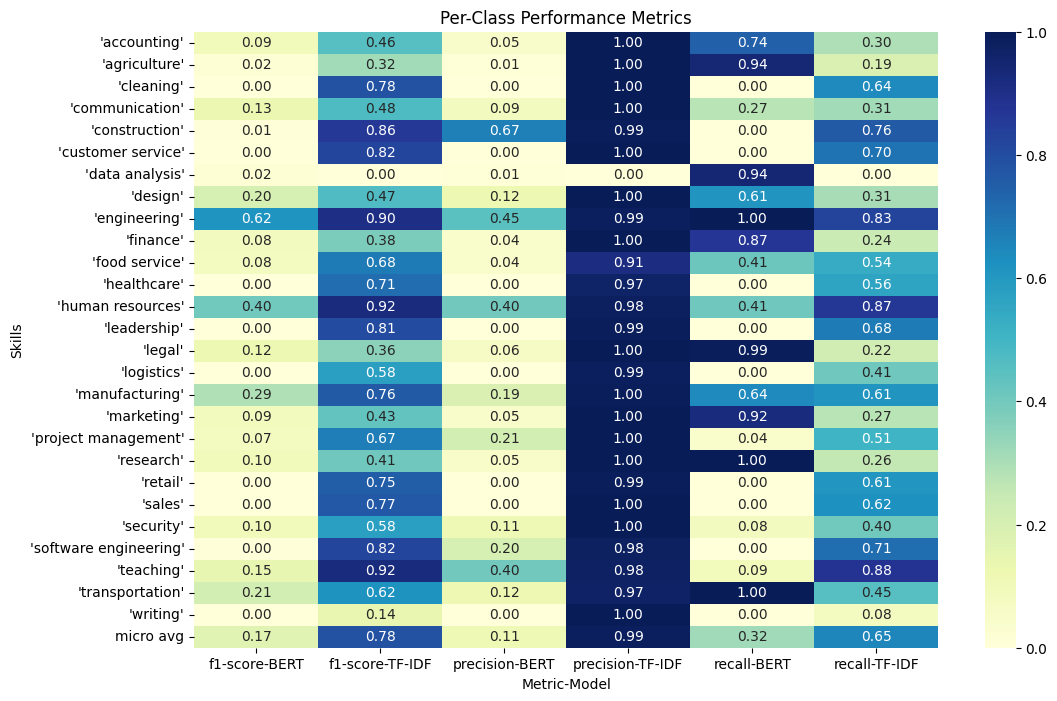

In [27]:
import seaborn as sns

# Convert classification reports to DataFrames
report_tfidf_df = pd.DataFrame(report_tfidf).transpose()
report_bert_df = pd.DataFrame(report_bert).transpose()

# Remove 'accuracy', 'macro avg', and 'weighted avg' rows
report_tfidf_df = report_tfidf_df.iloc[:-3, :]
report_bert_df = report_bert_df.iloc[:-3, :]

# Add a column to identify the model
report_tfidf_df['Model'] = 'TF-IDF'
report_bert_df['Model'] = 'BERT'

# Combine the DataFrames
reports_combined = pd.concat([report_tfidf_df, report_bert_df])

# Melt the DataFrame for plotting
reports_melted = reports_combined.reset_index().melt(
    id_vars=['index', 'Model'],
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
pivot_table = reports_melted.pivot_table(
    index='index', columns=['Metric', 'Model'], values='Score'
)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Per-Class Performance Metrics')
plt.ylabel('Skills')
plt.show()


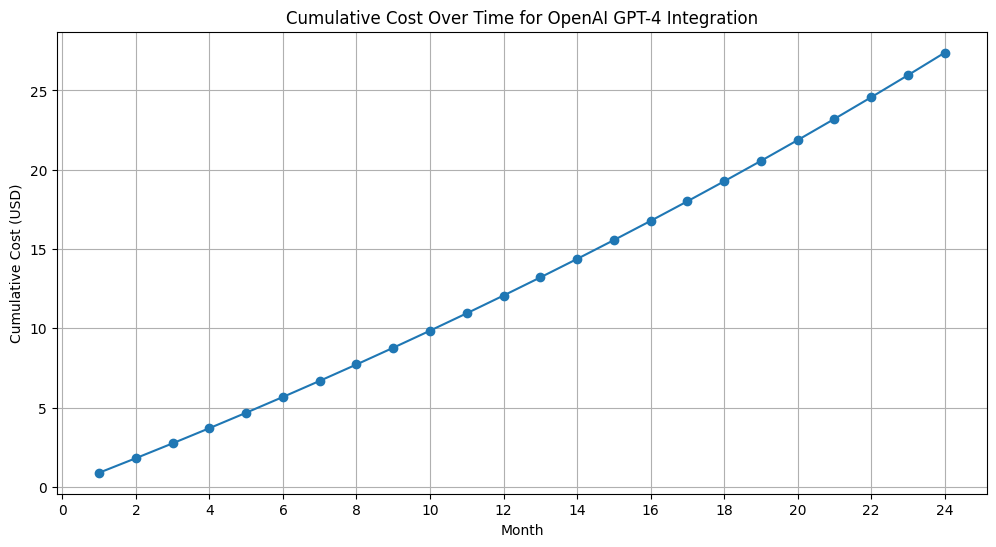

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
initial_users = 10
final_users = 10000
growth_rate = 0.02  # 2% monthly
months = 24  # Two years

# Generate user counts for each month
users = [initial_users]
for _ in range(1, months):
    users.append(users[-1] * (1 + growth_rate))
users = np.array(users)

# Calculate cost per user per month
cost_per_request = 0.09  # USD
requests_per_user = 1  # Assuming 1 request per user
monthly_cost = users * requests_per_user * cost_per_request

# Cumulative cost
cumulative_cost = np.cumsum(monthly_cost)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, months + 1), cumulative_cost, marker='o')
plt.title('Cumulative Cost Over Time for OpenAI GPT-4 Integration')
plt.xlabel('Month')
plt.ylabel('Cumulative Cost (USD)')
plt.grid(True)
plt.xticks(range(0, months + 1, 2))
plt.show()
